 
## Artificial Intelligence B

In this practical we look at the details of information gain and entropy in building decision trees. Then we examine the issues of overfitting and generalisation.

In [2]:
# first import some libraries
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

We will generate an artificial data set ourselves with the following attributes:

- N = 500
- Feature 1 is "Happiness",  numeric value
- Feature 2 is "Friendliness", numeric value
- Target is "Successful", boolean value 

To generate the artificial data we use the method described here:
- sklearn.datasets.make_classification


In [192]:
# we will generate data with a random process
# here we set the pseudo random seed (if we keep it the same the same
# random values will be generated)
np.random.seed(30)

N=500
variable_names = ["age","happy", "friendly"]
target_name = "successful"

# generate randomised data with certain properties (see the data sets library)
predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                  n_informative=2, n_clusters_per_class=2,
                                                  n_samples=N)

data = pd.DataFrame(predictors, columns=variable_names)
data['age'] = data['age'] * 10 + 50
data['happy'] = data['happy'] + 6 
data['friendly'] = data['friendly'] + 6 
data[target_name] = target

# Our variables (features) will be stored in one variable called X
X = data[[variable_names[0],variable_names[1],variable_names[2]] ]

# Our target will be stored in one variable called Y
Y = data[target_name]


We can plot the variable age on the horizontal axis with the target variable colored blue and red depending on its value as follows:

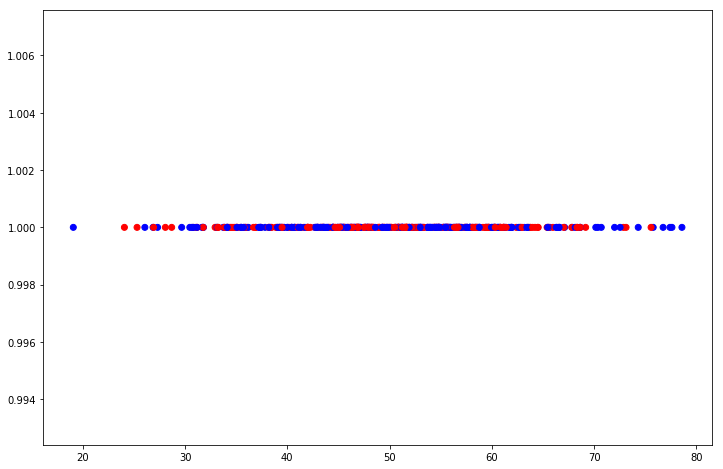

In [193]:
color = ["red" if x == 0 else "blue" for x in data["successful"]]
plt.scatter(X['age'], [1]*N,c=color)

### Question 1 

#### 1 a)
Use the head function to display the first 5 rows of the features and target.

In [194]:
data.head()

,age,happy,friendly,successful
0,40.046995,7.335667,7.773635,1
1,38.257957,5.273168,7.268721,0
2,37.829363,7.406738,6.742890,1
3,44.049927,4.554628,5.180865,0
4,59.651220,6.178452,7.026523,1


#### 1 b)
Use the plotting method we just used to show the pattern between age and success to plot the other variables AND answer the following question:

- From the graphs, identify which feature contains the most useful information for identifying which examples are successful? Explain. _In your answer refer to the graphs to assist in your explaination._

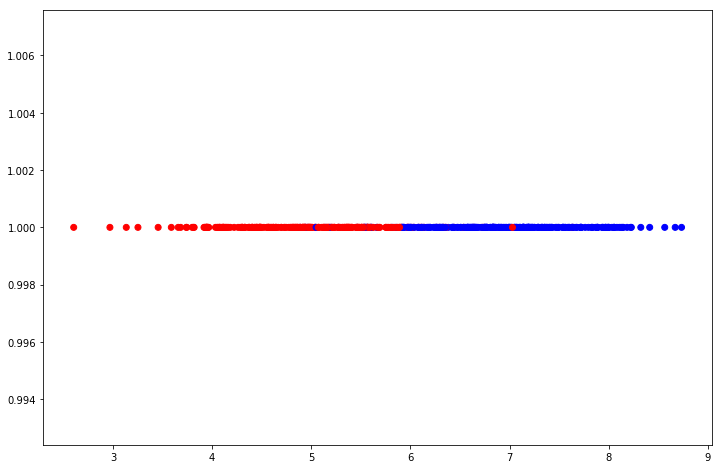

In [195]:
color = ["red" if x == 0 else "blue" for x in data["successful"]]
plt.scatter(X['happy'], [1]*N,c=color)

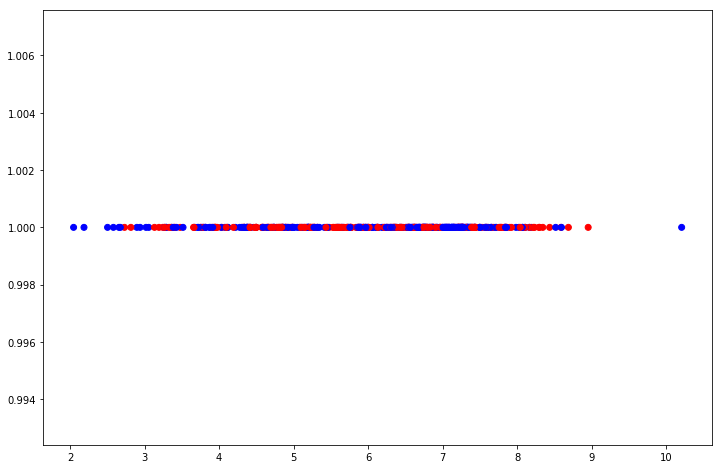

In [196]:
plt.scatter(X['friendly'], [1]*N,c=color)

#### 1 c)
Look at the plots generated in question 1b, are any variables good for identifying the value of successful? What is a good threshold for distinguishing successful or not?

happy = 6

#### 1 d)
Recall the way to calculate Entropy and Information to measure the purity of a set, and the resulting purity from a split.
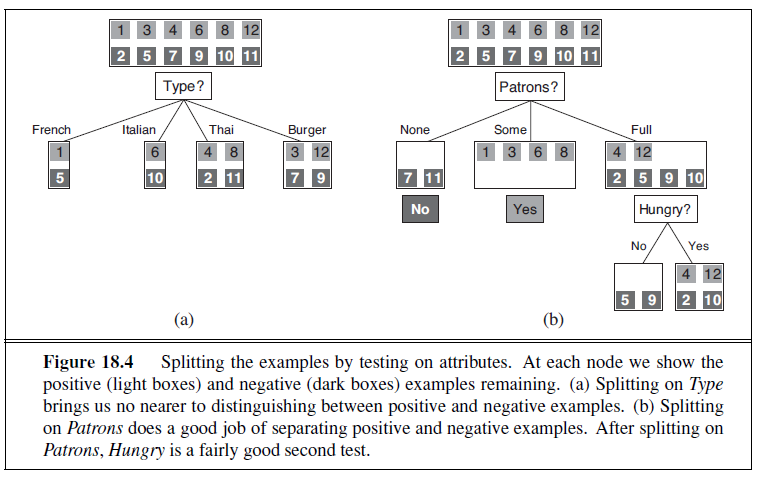

Write a function to calculate the entropy given a set of examples (the examples are be rows in a data frame structured as the target we just determined).

In [197]:
def entropy(target):
    # Get the number of instances
    n = len(target)
    # Count how frequently each unique target value occurs using the numpy function 
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    
    # Otherwise, for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            entropy += math.log(count/n, 2) * count/n
    # Return entropy
    return -1 * entropy

# TEST Your function.
# should be 1.0
test_array = [1,0,1,0,1,0]
print ( "entropy [1,0,1,0,1,0] = ",entropy (test_array))
# should be 0
test_array = [1,1]
print ( "entropy [1,1] = ",entropy (test_array))
# 0.91
test_array = [1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1]
print ( "entropy [1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1] = ",entropy (test_array))

entropy [1,0,1,0,1,0] =  1.0
entropy [1,1] =  -0.0
entropy [1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1] =  0.9182958340544898


#### 1 e)
Write a function to calculate the information gain obtained by splitting a numeric feature at a certain threshold. The function should return the Information Gain (IG):

- IG (parent, children) = entropy(parent)−(p(c1)×entropy(c1)+p(c2)×entropy(c2)) 

You can assume there are just two children because the threshold can only split the feature at one point.

Hint: use the features of Numpy Arrays to handle cutting the vector at a certain threshold
See https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html and example in the next cell.


In [198]:
def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
       
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    
    # For both sides of the threshold, update information gain
    for target_value, count in zip([0, 1], np.bincount(feature).astype(float)):
        #print ("count of %d = %d " % (target_value, count))
        ig -= count/len(feature) * entropy(target[feature == target_value])
    # Return information gain
    return ig

# Test your solution
# If you kept the same random seed IG is 
#Information Gain = 0.5461 with threshold = 6.00.

threshold = 6
inf_gain = information_gain(X['happy'], threshold, np.array(target))
print ("Information Gain = %.4f with threshold = %.2f." % (inf_gain, threshold))

Information Gain = 0.5461 with threshold = 6.00.


In [199]:
# Example of using numpy array to obtain a list of boolean values .
# corresponding to some condition. Here we find all the values more than 5.
eg = np.array([1,1,11,1,1,7,0,0,0,0,0,10])
(eg > 5)

array([False, False,  True, False, False,  True, False, False, False,
       False, False,  True])

#### 1 f)
Now that you can calculate the information gain for a split at a certain threshold on a numeric vector we can find the optimal split.

Write a function to return the best threshold and the information gain obtained for a split in the feature "happy"

In [200]:
def best_split_value():
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X['happy']:
        ig = information_gain(X['happy'], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print ( best_split_value() )

# Test: calling best_split_value() should return a maximum IG of 0.591  and a split on 5.9124


The maximum IG = 0.591 and it occured by splitting on 5.9124.


Congratulations - you just made a decision treee!!!

### Question 2

As you know, using sckit learn, it is possible to generate more complex decision trees. 

#### 2 a)
Write a function wrapper for the method plotting method defined in the matplotlib method used in sklearn _matplotlib.pyplot_, this method will nicely format a plot that consists of a scatterplot of two features and colors the points a different color depending on the label (ie the target). The colors should be set to be high contrasting colors so it is easy to read the figure.

- Method name: Plot_XYT
- Method parameters: 
-    data - data frame 
-    x_name - name of the x axis feature
-    y_name - name of the y axis feature
- name of the target 

NOTE: a function wrapper is a simple function that "wraps" a call to another method (in this case the other method is plt) and calls it in a specific way that is useful for the task at hand.

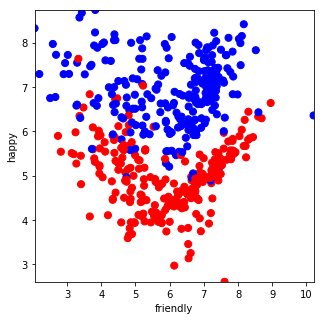

In [207]:
# method defintion
def Plot_XYT(data, x_name, y_name, t_name):
    import matplotlib.pyplot as plt
    # nicely format and print the plot here...
    ...


# Test your method by the following call
plt.figure(figsize=[5,5])
Plot_XYT(data, "friendly", "happy","successful")

#### 2 b)
In this question we fit a decision tree model that uses two of the features: friendly and happy.
Write code in sklearn using the DecisionTreeClassifier model (with entropy as the split criterion) that fits a decision tree model to the training data with just these 2 features. 

Create two decision tree models:
- One with maximum depth 2: model_depth_2
- Another with maximum depth: model_depth_5

In [208]:
# Our variables (features) will be stored in one variable called X
X = data[[variable_names[1],variable_names[2]] ]

# Our target will be stored in one variable called Y
Y = data[target_name]


# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=5,criterion="entropy")   # Look at those 2 arguments !!!



#### 2 c)
Draw tree diagrams for both of the models found in 2b using the method _sklearn.tree.plot_tree_.

[Text(313.425,405.057,'age <= 5.911\nentropy = 1.0\nsamples = 500\nvalue = [249, 251]'),
 Text(109.45,331.41,'age <= 4.886\nentropy = 0.392\nsamples = 246\nvalue = [227, 19]'),
 Text(89.55,257.763,'entropy = 0.0\nsamples = 109\nvalue = [109, 0]'),
 Text(129.35,257.763,'happy <= 6.691\nentropy = 0.581\nsamples = 137\nvalue = [118, 19]'),
 Text(79.6,184.117,'happy <= 5.884\nentropy = 0.789\nsamples = 72\nvalue = [55, 17]'),
 Text(39.8,110.47,'age <= 5.573\nentropy = 0.434\nsamples = 56\nvalue = [51, 5]'),
 Text(19.9,36.8233,'entropy = 0.179\nsamples = 37\nvalue = [36, 1]'),
 Text(59.7,36.8233,'entropy = 0.742\nsamples = 19\nvalue = [15, 4]'),
 Text(119.4,110.47,'age <= 5.496\nentropy = 0.811\nsamples = 16\nvalue = [4, 12]'),
 Text(99.5,36.8233,'entropy = 0.991\nsamples = 9\nvalue = [4, 5]'),
 Text(139.3,36.8233,'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(179.1,184.117,'age <= 4.888\nentropy = 0.198\nsamples = 65\nvalue = [63, 2]'),
 Text(159.2,110.47,'entropy = 0.0\nsamples = 1\

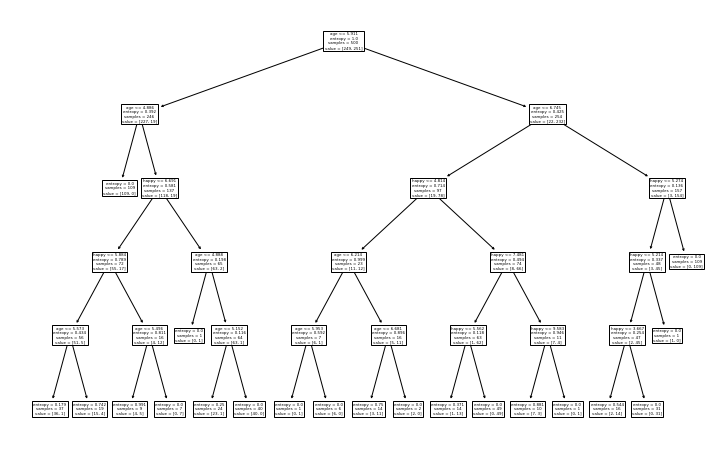

In [210]:
# Let's tell the model what is the data
decision_tree.fit(X, Y)

#Let's print an image with the results
tree.plot_tree(decision_tree, feature_names=variable_names)

#### 2 d) 
Write a function that plots the decision tree surface for two features variables (here we have the two variables friendly and happy). The function should plot the two features against each other  and color the points depending on whether the example is successful or not (as in question 2a), in addition the plot should show the decision boundary that is specified by the decision tree (i.e. it should color the plot background in two different colors depending whether the decision tree predicts the part of the feature space is 0 success or 1 success.

For an example of a decision surface see https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
In the example multiple graphs are required because there are more than 2 features, in this problem a single graph is required because we used only 2 features (happy and friendly).

HINT: to create the decision surface create a "meshed" grid using numpy.meshgrid: https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html 
Then plot both the mesh grid and the data points with different colors.


Use your method to plot the two models generated in question 2 c. Discuss the differences between the two models.

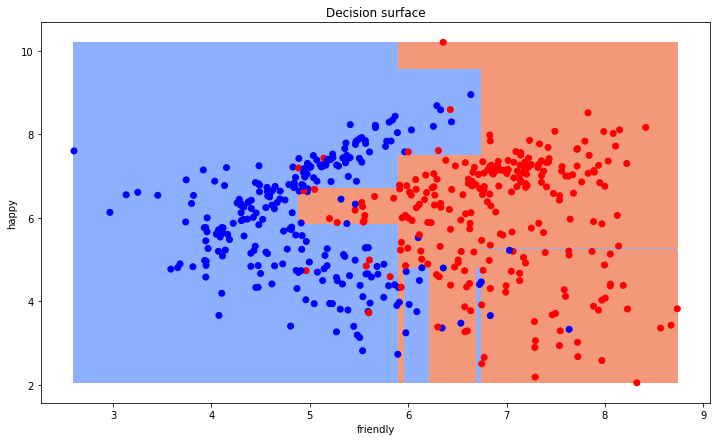

In [211]:
def Decision_Surface(data, target, model):
    # Get bounds
    x_min, x_max = data[data.columns[0]].min(), data[data.columns[0]].max()
    y_min, y_max = data[data.columns[1]].min(), data[data.columns[1]].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.01), np.arange(y_min, y_max,0.01))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    plt.figure(figsize=[12,7])
    Z = model.predict(meshed_data).reshape(xx.shape)
            
    plt.title("Decision surface")    
    plt.ylabel("happy")
    plt.xlabel("friendly")
    cs = plt.contourf(xx, yy, Z, levels=[-1,0,1],cmap=plt.cm.coolwarm,origin='lower')

    color = ["blue" if t == 0 else "red" for t in target]
    plt.scatter(data[data.columns[0]], data[data.columns[1]], color=color )

Decision_Surface(X,Y,decision_tree)

### Question 3

#### 3 a)
Generate three decision trees for the data and use the method from question 2 d to plot the decision surfaces, and the decision trees.

The trees should have depth that is: max depth 1, 2, 3, and 5.

What are the benefits of increasing the depth? What are the drawbacks. _Answer this question with respect to the figures of decision surfaces and trees just created_.

In [225]:
#code here


discussion here

#### 3 b)
Extend the method used for plotting the decision surface from decision tree models to also plot probabilities of different areas in the decision surface. The probability can be found using the method predict_probab: _decision_tree.predict_proba(X, check_input=True)_

Generate graphs showing the probabilities of regions of the decision surface for the models found in question 3a.

For example the decision tree with depth 5 looks like the following (lighter regions have lower probability):
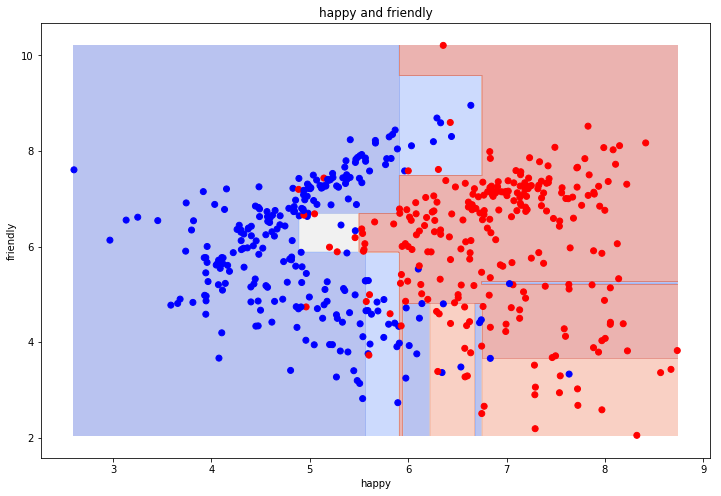

Extend your discussion from question 3a to include discussion of the probability and address the following issues:
- How many examples were used to determine the probabilities?
- How confident are we in the predictions from the model based on this information?

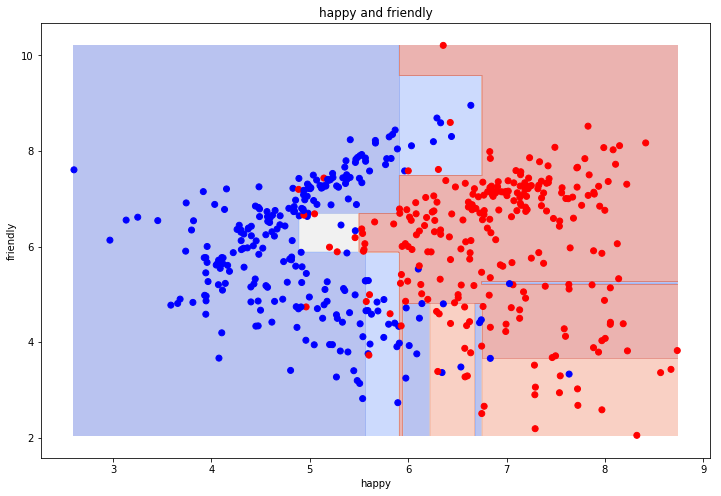

In [232]:
def Decision_Surface(data, target, model, surface=True, probabilities=False):
    '''
    This function creates the surface of a decision tree using the data created with this script. 
    You can change this function tu plot any column of any dataframe. 
    
    INPUT: data (created with data_tools.X() ),
            target (Y value creted with data_tools.create_data() ),
            model (Model already fitted with X and Y , i.e. DecisionTreeClassifier or logistic regression )
            surface (True if we want to display the tree surface),
            probabilities (False by default, if True we can see the color-scale based on the likelihood of being closer to the separator),
           cell_size (value for the step of the numpy arange that creates the mesh)

    RETURNS: Scatterplot with/without the surface
    '''
    cell_size=.01
    # Get bounds, we only have 2 columns in the dataframe: column 0 and column 1 
    x_min, x_max = data[data.columns[0]].min(), data[data.columns[0]].max()
    y_min, y_max = data[data.columns[1]].min(), data[data.columns[1]].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_size), np.arange(y_min, y_max, cell_size))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    # Add interactions
    for i in range(data.shape[1]):
        if i <= 1:
            continue

        meshed_data = np.c_[meshed_data, np.power(xx.ravel(), i)]

    if model != None:
        # Predict on the mesh with labels or probability
        if probabilities:
            Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
        else:
            Z = model.predict(meshed_data).reshape(xx.shape)
    
    # Plot mesh and data
    if data.shape[1] > 2:
        # Higher orders
        plt.title("humor^(" + str(range(1,data.shape[1])) + ") and number_pets")
    else:
        plt.title("happy and friendly")
    plt.xlabel("happy")
    plt.ylabel("friendly")
    if surface and model != None:
        if probabilities:
            # Color-scale on the contour (surface = separator)
            cs = plt.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.4)
        else:
            # Only a curve/line on the contour (surface = separator)
            cs = plt.contourf(xx, yy, Z, levels=[-1,0,1],cmap=plt.cm.coolwarm, alpha=0.4)
    color = ["blue" if t == 0 else "red" for t in target]
    plt.scatter(data[data.columns[0]], data[data.columns[1]], color=color)

    
Decision_Surface(X, Y, decision_tree, probabilities=True)

In [ ]:
discussion here

### Question 4

#### 4 a)
Now build a logistic regression model for the data set.

Plot the decision surface of the logistic regression model.

Discuss and compare the model generated from logistic regression with the decision tree. _To answer write down the equation of the decision boundary and comment on the main difference between this decision boundary and the decision boundary that you saw in the decision trees_.

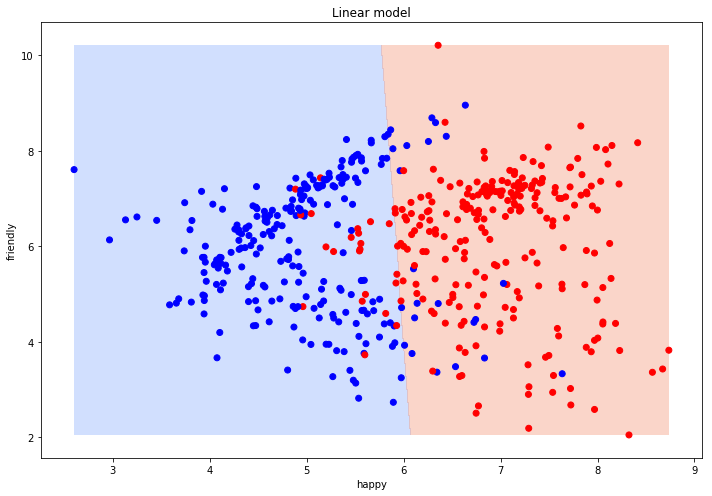

In [240]:
# libraries
from sklearn.linear_model import LogisticRegression

# Settings
show_probabilities = False

# Model
model = LogisticRegression(solver='lbfgs')
model.fit(X, Y)

# Plot
plt.figure(figsize=[10,7])
Decision_Surface(X, Y, model, probabilities=show_probabilities)
plt.title("Linear model")
plt.tight_layout()
plt.show()


discussion here

#### 4 b)

Extend the feature set we have to include the second and third powers of friendly.

To do this add columns to the feature data structure X that are in addition to happy and friendly the values 
- friendly$^2$ 
- friendly$^3$.

Generate logistic regression models with this data and draw these decision surfaces.

Discuss why we would want to do this and what is the benefit. _Refer to the figure you generated_.

In [ ]:
code

In [ ]:
discussion